The goal is to predict **Churn Value**.
    - 0: people left
    - 1: people don't leave

Dataset from IBM Base Samples, the dataset will predict if someone will stop using Telco's services or not using various categoical datatypes

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


In [2]:
#Predict if someone 
df = pd.read_csv('Telco_Customer_Churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## Missing Data

**Missing data** is **blank space** or **NA** that indicates failed to collect data for one of the fetures

**XGBoost**: default behavior for missing data is to identify missing values and make sure they are all 0

- Even in data has zero and use zero for missing data, **XGBoost** still works well


In [5]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

**Total Charges** is missing if **Tenure Months** equal to 0. These people also has **Churn Value** to 0 because they just signed up and haven't paid the bill yet. So we could set **Total Charges** to 0 or to reove them 

They are some data Total Charges is 0 as well. They didn't pay the bill even they have been on aborad for several month

In [6]:
df['TotalCharges'] = df.loc[(df['TotalCharges'] ==" "),'TotalCharges'] = 0

In [7]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

Replace all the missing value in all the columns of data as `_` in the dataframe

In [8]:
df.replace(' ', '_', regex=True, inplace=True)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No_phone_service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,0,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One_year,No,Mailed_check,56.95,0,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,0,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No_phone_service,DSL,Yes,...,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,0,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber_optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,0,Yes


#### Split Data

use X to represent columns of data that use to make classification and y(Churn Value) to represent the column to predict



In [9]:
X = df.drop(['Churn','customerID'], axis=1).copy()
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,0
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,0
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,0


In [10]:
df['Churn'].unique()

array(['No', 'Yes'], dtype=object)

In [11]:
#convert y to numeric value
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0) 
y.unique()

array([0, 1])

#### One-Hot Encoding

For example> For Payment Method, we have 

1. Mailed check
2. Electronic Check
3. Bank Transfer
4. Credit Card

If conver to numeric, **XGBoost** will cluster people with 4s and 3s together than people with 4s and 1s. So need to convert categories data, so there is no more or less similar to any other categories. The likelihood of 4s and 3s together is the same as 4s and 1s. 


#### Two ways

- `ColumnTransformer(scikit-learn)`: 
    - Pro: can validate the data that get in the future
    - Cons: **turns data into array and loses all column names**, make it harder to verify that your usage of `ColumnTransformer()` as you intended it
- `get_dummies(pands)`: 
    - Pro: keep data in dataframe and column names, easier to verify that it works as intended .
    - Cons: does not have the persistent behavior that `ColumnTransformer()` has


In [12]:
pd.get_dummies(X, columns=['PaymentMethod']).head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,...,No,No,Month-to-month,Yes,29.85,0,0,0,1,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One_year,No,56.95,0,0,0,0,1
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,53.85,0,0,0,0,1
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,...,No,No,One_year,No,42.30,0,1,0,0,0
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,...,No,No,Month-to-month,Yes,70.70,0,0,0,1,0


In [13]:
X_encoded = pd.get_dummies(X, columns = ['gender',
                                        'SeniorCitizen',
                                         'Partner', 
                                         'Dependents',
                                         'PhoneService',
                                         'MultipleLines', 
                                         'InternetService',
                                         'OnlineSecurity', 
                                         'OnlineBackup', 
                                         'DeviceProtection', 
                                         'TechSupport',
                                           'StreamingTV', 
                                         'StreamingMovies', 
                                         'Contract', 
                                         'PaperlessBilling',
                                         'PaymentMethod'])
X_encoded.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,1,29.85,0,1,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,34,56.95,0,0,1,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,2,53.85,0,0,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,45,42.30,0,0,1,1,0,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,2,70.70,0,1,0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


## Split Data

In [14]:
sum(y)/len(y) #

0.2653698707936959

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state =42, stratify=y)

sum(y_train)/len(y_train)

0.2654297614539947

0.27 people left

`missing` tell what character to represent missing value

`missing =None`: means missing value is 0 or np.nan()

In [16]:
X_train.dtypes

tenure                                       int64
MonthlyCharges                             float64
TotalCharges                                 int64
gender_Female                                uint8
gender_Male                                  uint8
SeniorCitizen_0                              uint8
SeniorCitizen_1                              uint8
Partner_No                                   uint8
Partner_Yes                                  uint8
Dependents_No                                uint8
Dependents_Yes                               uint8
PhoneService_No                              uint8
PhoneService_Yes                             uint8
MultipleLines_No                             uint8
MultipleLines_No_phone_service               uint8
MultipleLines_Yes                            uint8
InternetService_DSL                          uint8
InternetService_Fiber_optic                  uint8
InternetService_No                           uint8
OnlineSecurity_No              

In [17]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing = None, seed=42)
clf_xgb.fit(X_train, y_train,
            verbose = True,
            early_stopping_rounds = 10, #if at some point, XGBoost not improve, build 10 more trees. Even those none of  10 trees improve predictions, it will stop
            eval_metric='aucpr', #use AUC to evaluate how prediction doing 
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.63563
[1]	validation_0-aucpr:0.64338
[2]	validation_0-aucpr:0.63966
[3]	validation_0-aucpr:0.63437
[4]	validation_0-aucpr:0.63576
[5]	validation_0-aucpr:0.63343
[6]	validation_0-aucpr:0.63292
[7]	validation_0-aucpr:0.63113


/Users/beckswu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-aucpr:0.63098
[9]	validation_0-aucpr:0.62656
[10]	validation_0-aucpr:0.63041


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

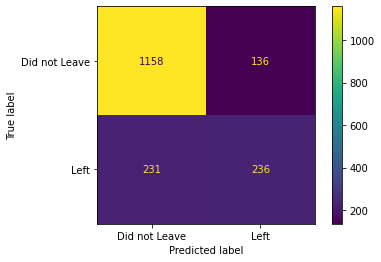

In [18]:
plot_confusion_matrix(clf_xgb,
                    X_test,
                    y_test,
                    values_format='d',
                    display_labels=["Did not Leave", "Left"])

For predicting people who left the company, XGBoost not doing a good lob, because data is imbalanced dataset. From Company point of view, people leaving costs the company a lot of money, would like to capture more of the people that left                

XGBoost has a parameter called `scale_pos_weight` that deal with imbalanced dataset. It adds the penalty to incorrectly predicted minority class. We want to increase this penalty that tree will correctly classify that. Try to improve predictions using Cross Validation to optimize the parameters

XGBoost has lot of hyparameters 

- `maxdepth`: the maximum tree depth
- `learning_rate`
- `gamma` parameter that encourages pruning 
- `reg_lambda`: regulariation parameter lambda

#Since we have many hyparameters to optimize, use `GridSearchCV`. Specify a bunch of potential values for the hyperparameters and `GridSearchCV()` . test all possible combinations of the parameters for us


When data are imbalanced, XGBoost manual says If care only about the overall performance metric (AUC) of your prediction. Balance the positive and negative weights vai `scale_pos_weight`


Use AUC as metric for evaluation

In [19]:
# Round 1
param_grid = {
    'max_depth': [3,4,5],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0,0.25,1.0],
    "reg_lambda": [0, 1.0, 10.0],
    "scale_pos_weight": [1,3,5]
}
#output: max_depth=4, learning_rate=0.1, gamma = 0.25, reg_lambda:10, scale_pos_weight=3

# Round 2
param_grid = {
    'max_depth': [4],
    "learning_rate": [0.1, 0.5, 1],
    "gamma": [0.25],
    "reg_lambda": [10, 20, 30],
    "scale_pos_weight": [3]
}
#Outut: max_depth=4, learning_rate=0.1, reg_lambda=10

optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='binary:logistic',
                                    seed=42,
                                    subsample=0.9, #to speed up not using all the data, using subset, 0.9 of total data which is randomly selected per tree
                                    colsample_bytree=0.5),#also search 50% columns for each tree. For every tree, we select different 50% of columns
                                                        #it helps overfitting and speed up 
    param_grid = param_grid,
    scoring='roc_auc',
    verbose = 0,
    n_jobs=10,
    cv=3
)

[0]	validation_0-aucpr:0.50098
[1]	validation_0-aucpr:0.60463
[2]	validation_0-aucpr:0.60756
[3]	validation_0-aucpr:0.61554
[4]	validation_0-aucpr:0.60801
[5]	validation_0-aucpr:0.60859
[6]	validation_0-aucpr:0.60985


/Users/beckswu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-aucpr:0.61409
[8]	validation_0-aucpr:0.61241
[9]	validation_0-aucpr:0.60951
[10]	validation_0-aucpr:0.60769
[11]	validation_0-aucpr:0.60720
[12]	validation_0-aucpr:0.60661
[13]	validation_0-aucpr:0.60626


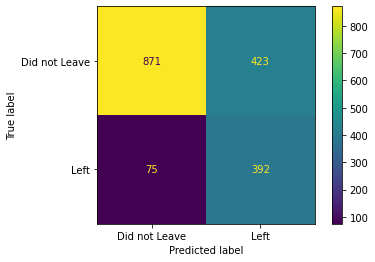

In [20]:


clf_xgb = xgb.XGBClassifier(
    seed = 42, 
    objective = 'binary:logistic',
    gamma = 0.25,
    learning_rate = 0.1,
    max_depth = 4,
    reg_lambda = 10,
    scale_pos_weight=3,
    subsample=0.9,
    colsample_bytree= 0.5
)


clf_xgb.fit(X_train, y_train,
            verbose = True,
            early_stopping_rounds = 10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])


plot_confusion_matrix(clf_xgb,
                    X_test,
                    y_test,
                    values_format='d',
                    display_labels=["Did not Leave", "Left"])
# then can see predict much better for the people who left the company
# But predicting people who don't leave worse than before

## Visualize tree

`n_estimators` = 1 tell XGBoost only build one tree, to draw first XGBoost Tree 


In [21]:
clf_xgb = xgb.XGBClassifier(
    seed = 42, 
    objective = 'binary:logistic',
    gamma = 0.25,
    learning_rate = 0.1,
    max_depth = 4,
    reg_lambda = 10,
    scale_pos_weight=3,
    subsample=0.9,
    colsample_bytree= 0.5,
    n_estimators = 1 #set to 1 so we can get gain, cover etc
)


clf_xgb.fit(X_train, y_train)

[21:10:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/beckswu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)


print wegiht, gain, cover for the tree
- `weight` = number of times a feature is used in a branch or root across all trees
- `gain` = the average gain across all splits that the feature is used_in
- `cover` = the average coverage across all splits a feature is used in
- `total_gain` = total gain across all the splits the feature is used in
- `total_cover` = total coverage across all splits the feature is used in


In [23]:
bst = clf_xgb.get_booster()

for importance_type in ('weight', 'gain', 'cover','total_gain', 'total_cover'):
    print("{}: {}".format(importance_type, bst.get_score(importance_type=importance_type)))

node_params = {"shape": 'box',
             'style': 'filled, rounded',
             'fillcolor': '#78cbe'}

leaf_params = {'shape':'box', 
              'style': 'filled',
              'fillcolor':'#e54302'}

graph_data = xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params= leaf_params)

graph_data.view(filename='xgboos_tree')





weight: {'TechSupport_No': 1, 'Contract_Two_year': 2, 'Contract_One_year': 2, 'OnlineSecurity_No_internet_service': 1, 'StreamingMovies_Yes': 1, 'PaperlessBilling_No': 2, 'StreamingMovies_No': 1}
gain: {'TechSupport_No': 1133.81055, 'Contract_Two_year': 228.0133975, 'Contract_One_year': 176.919701, 'OnlineSecurity_No_internet_service': 47.9323769, 'StreamingMovies_Yes': 49.5997925, 'PaperlessBilling_No': 23.01697445, 'StreamingMovies_No': 10.5443726}
cover: {'TechSupport_No': 1820.25, 'Contract_Two_year': 849.625, 'Contract_One_year': 780.75, 'OnlineSecurity_No_internet_service': 299.0, 'StreamingMovies_Yes': 185.0, 'PaperlessBilling_No': 495.25, 'StreamingMovies_No': 121.0}
total_gain: {'TechSupport_No': 1133.81055, 'Contract_Two_year': 456.026795, 'Contract_One_year': 353.839402, 'OnlineSecurity_No_internet_service': 47.9323769, 'StreamingMovies_Yes': 49.5997925, 'PaperlessBilling_No': 46.0339489, 'StreamingMovies_No': 10.5443726}
total_cover: {'TechSupport_No': 1820.25, 'Contract_Tw

'xgboos_tree.pdf'

Each branch either says **yes** or **no** and some also say **missing**
 - yes and no refer to whether the threshold in the node above it is true or not. If so, then yes, if not, then no
 - missing is the fault option if there is missing data
 
 Leaf tells the output value for each leaf